In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# add the path to my packages to system paths so they can be imported
import sys
sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages')
# sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

# import compare_with_benchmark as bn
import my_simgraph_04 as sg
import data_handler_01 as dh

/home/yasamanparhizkar/Documents/yorku/01_thesis/pyenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load spike data

Spike data shape:  (297, 1141, 113) $\implies$ (movie repeats, frames/time, neurons)
<br>
Labels are 1 (= spike) or -1 (= no spike).

In [2]:
# load all spike data from file
spikes_dp = '../../data/original_files/spikes.csv'
binned_data = np.loadtxt(spikes_dp, delimiter=',')
binned_data = binned_data.reshape(binned_data.shape[0], 1141, 113)
binned_data = binned_data * 2 - 1     # turn labels from 0,1 to -1,1

I_order_10 = [54, 35, 10, 60, 74, 9, 61, 56, 91, 104]

## Group all 113 neurons

This will create a more balanced dataset which is presumabley easier to solve.
<br>
Grouped data shape:  (297, 1141, 1) $\implies$ (movie repeats, frames/time, group)

In [3]:
# group all neurons together
grouped_data = np.zeros((297, 1141, 1))
for trial in range(297):
    for frame in range(1141):
        grouped_data[trial, frame, :] = 2 * int((binned_data[trial, frame, :] == 1).any()) - 1

In [4]:
# print some statistics
print('grouped_data.shape = ', grouped_data.shape)

avg_spike_perc = 0
print('trial #    | percentage belonging to class 1')
print('---------------------------------------------')
for trial in range(10):
    pers = dh.class_percentages(grouped_data[trial, :, :].reshape(-1), [-1, 1])
    avg_spike_perc += pers[1]
    print('trial #{:3} | {:.2f} %'.format(trial, pers[1]))

avg_spike_perc /= 10
print('---------------------------------------------')
print('AVERAGE     | {:.2f} %'.format(avg_spike_perc))

total_perc = np.sum(grouped_data == 1) *100 /(grouped_data.shape[0] * grouped_data.shape[1])
print('---------------------------------------------')
print('{:.2f} % of the whole data belongs to class 1.'.format(total_perc))

grouped_data.shape =  (297, 1141, 1)
trial #    | percentage belonging to class 1
---------------------------------------------
trial #  0 | 66.26 %
trial #  1 | 69.06 %
trial #  2 | 67.92 %
trial #  3 | 71.08 %
trial #  4 | 68.97 %
trial #  5 | 68.27 %
trial #  6 | 66.87 %
trial #  7 | 65.82 %
trial #  8 | 67.66 %
trial #  9 | 68.19 %
---------------------------------------------
AVERAGE     | 68.01 %
---------------------------------------------
68.47 % of the whole data belongs to class 1.


# Create training and validation datasets

In [5]:
# only consider the second trial
ind_min = 1*1141+0
ind_max = 2*1141-1
# train_num = int(data_num*0.8)
# val_num = data_num - train_num
train_num = 10
val_num = 10

def transform(fv):
    """
    Transform to be applied on feature vectors.
    
    Input: fv
    fv - 1xDf torch tensor representing a feature vector
    
    Output: fvv
    fvv - 1xDf' torch tensor representing the transformed feature vector
    """
    
    # for faster run and less memory usage
    fvv = fv[:, ::10]
    
    # for numerical stability during GD
    # fvv = fvv * 10
    
    return fvv

data_params = {'func': dh.datapoint, 'features_dp': '../../data/slowfast_4732/', \
               'spike_data': grouped_data, 'group_id': 0, 'transform': transform}

train_num, val_num, train_data, val_data = \
dh.random_train_val(train_num, val_num, ind_min, ind_max, data_params, seed=1342)

# show statistics
print('train_num = ', train_num, ', val_num = ', val_num)
print('training data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(train_data['lbls'] == 1), np.sum(train_data['lbls'] == 1)*100/train_num))
print('validation data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(val_data['lbls'] == 1), np.sum(val_data['lbls'] == 1)*100/val_num))

# print('train_smpls = ', train_data['smpls'], '\nval_smpls = ', val_data['smpls'])
# print('train_lbls = ', train_data['lbls'], '\nval_lbls = ', val_data['lbls'])
# print('train_des = ', train_data['des'], '\nval_des = ', val_data['des'])

train_num =  10 , val_num =  10
training data contains 7 points (70.00%) of label 1.
validation data contains 6 points (60.00%) of label 1.


## Normalize feature vectors

Taken from 'code/03_mnist/sift_on_mnist/sift_on_mnist_06.ipynb' with small changes.

In [6]:
train_dess_nrm = dh.normalize(train_data['des'], feature_nrm=1, node_nrm=30)  
val_dess_nrm = dh.normalize(val_data['des'], feature_nrm=1, node_nrm=30)

## snippet to update a set (training or validation)

In [7]:
# # update the validation set, so that it doesn't overlap with the training or the previous validation set
# val_num = 10
# minus_set = np.append(val_data['smpls'], train_data['smpls'])
# val_num, val_smpls = dh.update_indices(val_num, ind_min, ind_max, minus_set, seed=None)
# val_dess, val_lbls = dh.update_set(val_smpls, data_params)
# val_data   = {'des': val_dess, 'lbls': val_lbls, 'smpls': val_smpls}

# # show statistics
# print('new val_num = ', val_num)
# print('validation data contains {} points ({:.2f}%) of label 1.'
#       .format(np.sum(val_data['lbls'] == 1), np.sum(val_data['lbls'] == 1)*100/val_num))
# # print('val_smpls = ', val_data['smpls'])
# # print('val_lbls = ', val_data['lbls'])
# # print('val_des = ', val_data['des'])

# Learn the similarity graph

In [8]:
# reload sg package
# import importlib
# importlib.reload(sg)

In [9]:
# learning phase
sg_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 2, \
              'num_its':16, 'check_freq':1, 'print_checks':True, 'Theta0':None, \
              'force_all_its': True, 'threshold': 0.01}

# B, sg_stats = sg.fit_graph(train_dess_nrm, train_data['lbls'], sg_opt_params, mu=30, Dt=None, seed=0, edges_tt=None)
B, sg_stats = sg.fit_graph(train_data['des'], train_data['lbls'], sg_opt_params, mu=30, Dt=None, seed=0, edges_tt=None)

Number of training datapoints: 10
Number of features for each point: 474
mu = 30
SG edges are: [(0, 3), (0, 7), (0, 8), (1, 3), (1, 7), (1, 8), (2, 3), (2, 7), (2, 8), (3, 4), (3, 5), (3, 6), (3, 9), (4, 7), (4, 8), (5, 7), (5, 8), (6, 7), (6, 8), (7, 9), (8, 9)]
   0: eps = 1.56e-02;  train loss (E) = 53.11
   1: eps = 3.91e-03;  train loss (E) = 37.54
   2: eps = 7.81e-03;  train loss (E) = 15.18
   3: eps = 7.81e-03;  train loss (E) = 11.76
   4: eps = 3.91e-03;  train loss (E) = 10.66
   5: eps = 3.91e-03;  train loss (E) = 10.33
   6: eps = 7.81e-03;  train loss (E) = 10.18
   7: eps = 3.91e-03;  train loss (E) = 10.10
   8: eps = 3.91e-03;  train loss (E) = 10.04
   9: eps = 7.81e-03;  train loss (E) = 10.03
  10: eps = 3.91e-03;  train loss (E) = 10.00
  11: eps = 3.91e-03;  train loss (E) =  9.91
  12: eps = 3.91e-03;  train loss (E) =  9.88
  13: eps = 3.91e-03;  train loss (E) =  9.85
  14: eps = 3.91e-03;  train loss (E) =  9.83
  15: eps = 7.81e-03;  train loss (E) =  9.83


## Display learned metric matrix

Coordinates of elements with higher values than 0.011130897233908185
[(282, 96), (282, 113), (282, 278), (96, 282), (113, 282), (278, 282), (282, 282), (330, 282), (334, 282), (347, 282), (434, 282), (452, 282), (282, 330), (282, 334), (334, 334), (434, 334), (282, 347), (386, 386), (282, 434), (334, 434), (282, 452)]


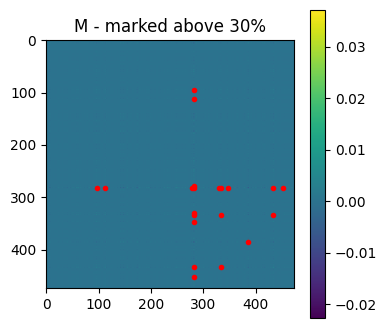

In [10]:
# display learned M
M = B.T @ B
# to preserve memory, uncomment below line
# del B

sg.display_matrix(M, None)

# mark elements with high values
thresh = 30
lim = (thresh/100) * np.max(M) # marker threshold
f_sz = M.shape[0]
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
plt.plot(xloc[M > lim],yloc[M > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M - marked above {}%'.format(thresh))
print('Coordinates of elements with higher values than {}'.format(lim))
print(list(zip(xloc[M > lim],yloc[M > lim])))

# save results
plt.savefig('../../data/slowfast_results/results-4732-1/finalM_'+str(0)+'.png')
# plt.close()
# np.savetxt('results/sg_finalB.csv', B, delimiter=',')

# Validate the similarity graph

In [11]:
# acc, y_est, t = sg.get_acc(B, train_dess_nrm, train_data['lbls'], val_dess_nrm, val_data['lbls'], Dv=0, Dvt=1, seed=0, show_edges=True)
val_acc, y_est, t = sg.get_acc(B, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], Dv=0, Dvt=2000, seed=0, show_edges=True)

edges between val. nodes:
 []
edges between val. and train. nodes:
 [(0, 8), (0, 3), (0, 7), (0, 0), (0, 9), (0, 1), (1, 3), (1, 7), (1, 8), (1, 4), (1, 9), (1, 6), (2, 8), (2, 7), (2, 3), (2, 4), (2, 0), (2, 2), (3, 3), (3, 7), (3, 8), (3, 9), (3, 6), (3, 0), (4, 8), (4, 3), (4, 7), (4, 0), (4, 9), (4, 2), (5, 8), (5, 3), (5, 7), (5, 4), (5, 2), (5, 5), (6, 3), (6, 8), (6, 7), (6, 5), (6, 4), (6, 6), (7, 8), (7, 7), (7, 3), (7, 9), (7, 4), (7, 6), (8, 3), (8, 7), (8, 8), (8, 0), (8, 4), (8, 6), (9, 8), (9, 7), (9, 3), (9, 4), (9, 2), (9, 9)]


In [12]:
print('val acc = {:.2f}%'.format(val_acc*100))
print('elapsed time = {:.2f} ms'.format(t*1000))
print('estimated val labels = ', 2*(y_est>0).astype(np.int32)-1)

# # save results
# np.savetxt('results/sg_val_acc.txt', np.array([acc]))
# np.savetxt('results/sg_y_est.csv', y_est, delimiter=',')

val acc = 70.00%
elapsed time = 25.96 ms
estimated val labels =  [ 1 -1 -1 -1 -1 -1  1 -1  1 -1]


In [13]:
# comparing estimated and real spike locations
val_loc = np.arange(val_num)
val_spikes = val_loc[val_data['lbls']==1]
est_spikes = val_loc[y_est > 0]

if sum(val_data['lbls']==1) == 0:
    missed = 0
else:
    missed = sum(np.logical_and(val_data['lbls']==1, y_est < 0))/sum(val_data['lbls']==1)

if sum(val_data['lbls']==-1) == 0:
    false_alarm = 0
else:
    false_alarm = sum(np.logical_and(val_data['lbls']==-1, y_est > 0))/sum(val_data['lbls']==-1)

nospk_per = np.sum(val_data['lbls']==-1)/val_num
min_acc = max(nospk_per, 1-nospk_per)

print('Estimated spike time bins: ', est_spikes)
print('Real spike time bins: ', val_spikes)
print('{:.2f}% of validation points have label {} (= min accuracy)'.format(min_acc*100, -1 if nospk_per > 50 else 1))
print('Missed spikes (/all spikes): {:.2f}%'.format(missed*100))
print('False spikes (/all no-spike bins): {:.2f}%'.format(false_alarm*100))

Estimated spike time bins:  [0 6 8]
Real spike time bins:  [0 2 5 6 7 8]
60.00% of validation points have label 1 (= min accuracy)
Missed spikes (/all spikes): 50.00%
False spikes (/all no-spike bins): 0.00%


## Save validation results

In [14]:
# prepare results file
with open('../../data/slowfast_results/sg_4732_res_1.txt', 'w') as file:    
    arr = ('{:^10} | {:^10} | {:^10} | {:^10} | {:^10} | {:^17} | {:^17} \n'\
           .format('i', 'train_num', 'val_num', 'min_acc(%)', 'val_acc(%)',\
                   'missed spks(%)', 'false alarms(%)'),'-'*101+'\n')
    file.writelines(arr)

# save the experiment's results
with open('../../data/slowfast_results/sg_4732_res_1.txt', 'a') as file:
    file.write('{:^10} | {:^10} | {:^10} | {:^10.2f} | {:^10.2f} | {:^17.2f} | {:^17.2f} \n'\
               .format(0, train_num, val_num, min_acc*100, val_acc*100, missed*100, false_alarm*100))

# Assess the model's performance with random tests

## set parameters

In [15]:
# only consider the second trial
ind_min = 1*1141+0
ind_max = 2*1141-1

def transform(fv):
    """
    Transform to be applied on feature vectors.
    
    Input: fv
    fv - 1xDf torch tensor representing a feature vector
    
    Output: fvv
    fvv - 1xDf' torch tensor representing the transformed feature vector
    """
    
    # for faster run and less memory usage
    fvv = fv[:, ::10]
    
    # for numerical stability during GD
    # fvv = fvv * 10
    
    return fvv

data_params = {'func': dh.datapoint, 'features_dp': '../../data/slowfast_4732/', \
               'spike_data': grouped_data, 'group_id': 0, 'transform': transform}

sg_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 2, \
                              'num_its':16, 'check_freq':1, 'print_checks':False, 'Theta0':None, \
                              'force_all_its': True, 'threshold': 0.01}

# try various training and validation set sizes
train_sizes = [10, 15, 20]
val_sizes = [5, 10]

# for each set size, try a number of random combinations of datapoints
train_combs = 2
val_combs = 3

thresh = 30
f_sz = 474 # must match data_params
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T

mu = 30
Dt = None
Dv = 0
Dvt = 2000
edges_tt = None

res_path = '../../data/slowfast_results/results-4732/'

## randomized experiments

In [16]:
def get_valset(train_data, val_num, ind_min, ind_max, data_params):
    minus_set = train_data['smpls']
    val_num, val_smpls = dh.update_indices(val_num, ind_min, ind_max, minus_set, seed=None)
    val_dess, val_lbls = dh.update_set(val_smpls, data_params)
    val_data   = {'des': val_dess, 'lbls': val_lbls, 'smpls': val_smpls}
    
    return val_num, val_data

def visualize_M(B, thresh, xloc, yloc, train_comb, train_num, val_num, res_path):
    M = B.T @ B
    sg.display_matrix(M, None)
    # mark prominent elements          
    lim = (thresh/100) * np.max(M) # marker threshold                
    plt.plot(xloc[M > lim],yloc[M > lim], marker='o', markersize=3, color='r', linestyle='')
    plt.title('M - marked above {}%'.format(thresh))
    # save figure
    plt.savefig(res_path+'finalM_'+str(val_num)+'_'+str(train_num)+'_'+str(train_comb)+'.png')
    plt.close()
    
def assessment_quantities(val_data, val_num, y_est, val_acc):
    nospk_per = np.sum(val_data['lbls']==-1)/val_num
    min_acc = max(nospk_per, 1-nospk_per)
    if sum(val_data['lbls']==1) == 0:
        missed = 0
    else:
        missed = sum(np.logical_and(val_data['lbls']==1, y_est < 0))/sum(val_data['lbls']==1)

    if sum(val_data['lbls']==-1) == 0:
        false_alarm = 0
    else:
        false_alarm = sum(np.logical_and(val_data['lbls']==-1, y_est > 0))/sum(val_data['lbls']==-1)
        
    assess_qs = {'min_acc': min_acc, 'val_acc': val_acc, 'missed': missed, 'false_alarm': false_alarm}
        
    return assess_qs

def make_line(head, train_num, val_num, res_dict, index):
    line = '{:^10} | {:^10} | {:^10} | {:^10.2f} | {:^10.2f} | {:^17.2f} | {:^17.2f} \n'\
           .format(head, train_num, val_num, \
                   res_dict['min_acc'][index]*100, \
                   res_dict['val_acc'][index]*100, \
                   res_dict['missed'][index]*100, \
                   res_dict['false_alarm'][index]*100)
    return line

def take_train_step(train_num, val_num, ind_min, ind_max, data_params, sg_opt_params, mu, Dt, edges_tt, thresh, xloc, yloc,  train_comb, res_path, seed=None):
    # create training set
    train_num, _, train_data, _ = dh.random_train_val(train_num, val_num, ind_min, ind_max, data_params, seed)

    # train the model              
    B, sg_stats = sg.fit_graph(train_data['des'], train_data['lbls'], sg_opt_params, mu, Dt, seed, edges_tt)

    # visualize learned M
    visualize_M(B, thresh, xloc, yloc, train_comb, train_num, val_num, res_path)
    
    return train_num, train_data, B, sg_stats

def take_val_step(train_data, val_num, ind_min, ind_max, data_params, B, Dv, Dvt, seed=None):
    # create validation set, NO overlap with the training set
    val_num, val_data = get_valset(train_data, val_num, ind_min, ind_max, data_params)

    # validate the model
    val_acc, y_est, t = sg.get_acc(B, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], Dv, Dvt, seed, show_edges=False)

    # compute several assessment quantities
    assess_qs = assessment_quantities(val_data, val_num, y_est, val_acc)
    
    return val_num, val_data, assess_qs, y_est, t

def avg_and_log(next_dict, prev_dict, index, head, train_num, val_num, func, path):
    # compute averages over random combinations of validation sets
    for quantity in prev_dict:
        if func == 'mean':
            next_dict[quantity][index] = np.mean(prev_dict[quantity])
        elif func == 'std':
            next_dict[quantity][index] = np.std(prev_dict[quantity])
        else:
            assert False

    # save on file
    with open(path+'log.txt', 'a') as file:
        line = make_line(head, train_num, val_num, next_dict, index)
        file.write(line)
        
    return next_dict

In [17]:
def assess_sg_model(train_sizes, val_sizes, train_combs, val_combs, mu, Dt, Dv, Dvt, edges_tt, res_path, data_params, sg_opt_params, ind_min, ind_max, thresh, f_sz, xloc, yloc, seed=None):
    # prepare results file
    with open(res_path+'log.txt', 'w') as file:    
        arr = ('{:^10} | {:^10} | {:^10} | {:^10} | {:^10} | {:^17} | {:^17} \n'\
               .format('i', 'train_num', 'val_num', 'min_acc(%)', 'val_acc(%)',\
                       'missed spks(%)', 'false alarms(%)'),'-'*101+'\n')
        file.writelines(arr)

    # create dictionaries to keep interesting variables
    assess_qs = {'min_acc': 0, 'val_acc': 0, 'missed': 0, 'false_alarm': 0}
    val_comb_res = {}
    train_comb_res = {}
    train_num_res = {}
    train_num_err = {}
    val_num_res = {}
    val_num_err = {}
    for quantity in assess_qs:
        val_comb_res[quantity] = np.zeros(val_combs)
        train_comb_res[quantity] = np.zeros(train_combs)
        train_num_res[quantity] = np.zeros(len(train_sizes))
        train_num_err[quantity] = np.zeros(len(train_sizes))
        val_num_res[quantity] = np.zeros(len(val_sizes))
        val_num_err[quantity] = np.zeros(len(val_sizes))

    i = 0
    for val_num in val_sizes:
        j = 0
        for train_num in train_sizes:
            for train_comb in range(train_combs):
                # train
                train_num, train_data, B, sg_stats = \
                take_train_step(train_num, val_num, ind_min, ind_max, data_params, sg_opt_params, mu, Dt, edges_tt, thresh, xloc, yloc, train_comb, res_path, seed)

                for val_comb in range(val_combs):
                    # validate
                    val_num, val_data, assess_qs, y_est, t = \
                    take_val_step(train_data, val_num, ind_min, ind_max, data_params, B, Dv, Dvt, seed)
                    # log resutls
                    val_comb_res = avg_and_log(val_comb_res, assess_qs, val_comb, str(val_comb), train_num, val_num, 'mean', res_path)

                # average over various validation set combinations and log
                train_comb_res = avg_and_log(train_comb_res, val_comb_res, train_comb, '>'+str(train_comb), train_num, val_num, 'mean', res_path)
            # average over various training and validation set combinations and log
            train_num_res = avg_and_log(train_num_res, train_comb_res, j, '*t*', train_num, val_num, 'mean', res_path)
            train_num_err = avg_and_log(train_num_err, train_comb_res, j, '*te*', train_num, val_num, 'std', res_path)
            j += 1
        # average over various training set sizes and training and validation set combinations, and log
        val_num_res = avg_and_log(val_num_res, train_num_res, i, '**v**', train_num, val_num, 'mean', res_path)
        val_num_err = avg_and_log(val_num_err, train_num_res, i, '**ve**', train_num, val_num, 'std', res_path)
        i += 1   
        # save train_num_res curves for this specific val_num
        with open(res_path+'curves_'+str(i-1)+'.txt', 'w') as file:
            for quantity in assess_qs:
                np.savetxt(file, train_num_res[quantity])
                np.savetxt(file, train_num_err[quantity])
                file.write('\n')
        
    return val_num_res, val_num_err
    

In [18]:
val_num_res, val_num_err = assess_sg_model(train_sizes, val_sizes, train_combs, val_combs, mu, Dt, Dv, Dvt, edges_tt, res_path, data_params, sg_opt_params, ind_min, ind_max, thresh, f_sz, xloc, yloc)

# print average results
print(val_num_res)
print(val_num_err)

{'min_acc': array([0.73333333, 0.72222222]), 'val_acc': array([0.62222222, 0.62222222]), 'missed': array([0.46388889, 0.4276455 ]), 'false_alarm': array([0.17592593, 0.33333333])}
{'min_acc': array([0.04714045, 0.04157397]), 'val_acc': array([0.13425607, 0.05499719]), 'missed': array([0.28208695, 0.13989341]), 'false_alarm': array([0.11638708, 0.21245915])}


## Plot several assessment quantities

In [20]:
curves = {}
errors = {}
for i in range(len(val_sizes)):
    curves_i = np.loadtxt(res_path+'curves_'+str(i)+'.txt')
    curves_i = curves_i.reshape(8, -1)
    j = 0
    for quantity in val_num_res:
        if i == 0:
            curves[quantity] = curves_i[2*j].reshape(1, -1)
            errors[quantity] = curves_i[2*j+1].reshape(1, -1)
        else:
            curves[quantity] = np.concatenate((curves[quantity], [curves_i[2*j]]), axis=0)
            errors[quantity] = np.concatenate((errors[quantity], [curves_i[2*j+1]]), axis=0)
        j += 1
        
print('curves:\n', curves)
print('errors:\n', errors)

curves:
 {'min_acc': array([[0.66666667, 0.76666667, 0.76666667],
       [0.76666667, 0.66666667, 0.73333333]]), 'val_acc': array([[0.43333333, 0.73333333, 0.7       ],
       [0.63333333, 0.55      , 0.68333333]]), 'missed': array([[0.86111111, 0.29722222, 0.23333333],
       [0.43452381, 0.59543651, 0.25297619]]), 'false_alarm': array([[0.13888889, 0.05555556, 0.33333333],
       [0.25      , 0.125     , 0.625     ]])}
errors:
 {'min_acc': array([[0.06666667, 0.03333333, 0.03333333],
       [0.06666667, 0.03333333, 0.06666667]]), 'val_acc': array([[0.1       , 0.06666667, 0.03333333],
       [0.16666667, 0.08333333, 0.01666667]]), 'missed': array([[0.13888889, 0.13055556, 0.1       ],
       [0.26785714, 0.08710317, 0.12202381]]), 'false_alarm': array([[0.13888889, 0.05555556, 0.33333333],
       [0.08333333, 0.125     , 0.375     ]])}


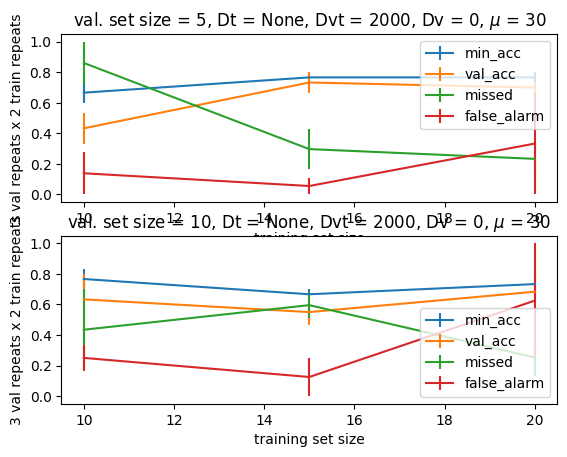

In [21]:
plt.figure()
for i in range(len(val_sizes)):
    plt.subplot(len(val_sizes), 1, i+1)
    for quantity in curves:
        plt.errorbar(train_sizes, curves[quantity][i], errors[quantity][i])
    plt.legend(curves.keys())
    plt.xlabel('training set size')
    plt.ylabel('{} val repeats x {} train repeats'.format(val_combs, train_combs))
    _ = plt.title('val. set size = {}, Dt = {}, Dvt = {}, Dv = {}, $\mu$ = {}'.format(val_sizes[i], 'None', 2000, 0, 30))
plt.savefig(res_path+'train_curves.png')

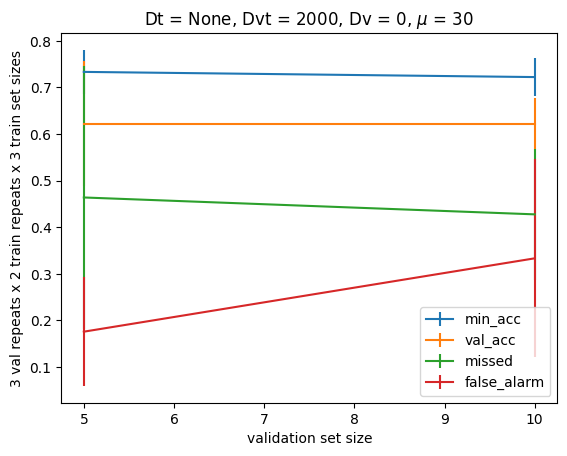

In [22]:
plt.figure()
for quantity in val_num_res:
    plt.errorbar(val_sizes, val_num_res[quantity], val_num_err[quantity])
plt.legend(val_num_res.keys())
plt.xlabel('validation set size')
plt.ylabel('{} val repeats x {} train repeats x {} train set sizes'.format(val_combs, train_combs, len(train_sizes)))
_ = plt.title('Dt = {}, Dvt = {}, Dv = {}, $\mu$ = {}'.format('None', 2000, 0, 30))
plt.savefig(res_path+'val_curves.png')

### make it a function

In [23]:
def plot_curves(train_sizes, val_sizes, val_num_res, val_num_err, res_path):
    curves = {}
    errors = {}
    for i in range(len(val_sizes)):
        curves_i = np.loadtxt(res_path+'curves_'+str(i)+'.txt')
        curves_i = curves_i.reshape(8, -1)
        j = 0
        for quantity in val_num_res:
            if i == 0:
                curves[quantity] = curves_i[2*j].reshape(1, -1)
                errors[quantity] = curves_i[2*j+1].reshape(1, -1)
            else:
                curves[quantity] = np.concatenate((curves[quantity], [curves_i[2*j]]), axis=0)
                errors[quantity] = np.concatenate((errors[quantity], [curves_i[2*j+1]]), axis=0)
            j += 1

    plt.figure()
    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.8,hspace=0.8)
    for i in range(len(val_sizes)):
        plt.subplot(len(val_sizes), 1, i+1)
        for quantity in curves:
            plt.errorbar(train_sizes, curves[quantity][i], errors[quantity][i])
        plt.legend(curves.keys())
        plt.xlabel('training set size')
        plt.ylabel('{} val repeats x {} train repeats'.format(val_combs, train_combs))
        _ = plt.title('val. set size = {}, Dt = {}, Dvt = {}, Dv = {}, $\mu$ = {}'.format(val_sizes[i], 'None', 2000, 0, 30))
    plt.savefig(res_path+'train_curves.png')
    plt.close()
    
    plt.figure()
    for quantity in val_num_res:
        plt.errorbar(val_sizes, val_num_res[quantity], val_num_err[quantity])
    plt.legend(val_num_res.keys())
    plt.xlabel('validation set size')
    plt.ylabel('{} val repeats x {} train repeats x {} train set sizes'.format(val_combs, train_combs, len(train_sizes)))
    _ = plt.title('Dt = {}, Dvt = {}, Dv = {}, $\mu$ = {}'.format('None', 2000, 0, 30))
    plt.savefig(res_path+'val_curves.png')
    plt.close()

In [24]:
plot_curves(train_sizes, val_sizes, val_num_res, val_num_err, res_path)

## Try various $\mu$ values

In [25]:
# only consider the second trial
ind_min = 1*1141+0
ind_max = 2*1141-1

def transform(fv):
    """
    Transform to be applied on feature vectors.
    
    Input: fv
    fv - 1xDf torch tensor representing a feature vector
    
    Output: fvv
    fvv - 1xDf' torch tensor representing the transformed feature vector
    """
    
    # for faster run and less memory usage
    fvv = fv[:, ::10]
    
    # for numerical stability during GD
    # fvv = fvv * 10
    
    return fvv

data_params = {'func': dh.datapoint, 'features_dp': '../../data/slowfast_4732/', \
               'spike_data': grouped_data, 'group_id': 0, 'transform': transform}

sg_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 2, \
                              'num_its':16, 'check_freq':1, 'print_checks':False, 'Theta0':None, \
                              'force_all_its': True, 'threshold': 0.01}

# try various training and validation set sizes
train_sizes = [10, 15, 20]
val_sizes = [5, 10]

# for each set size, try a number of random combinations of datapoints
train_combs = 2
val_combs = 3

thresh = 30
f_sz = 474 # must match data_params
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T

# mu = 30
Dt = None
Dv = 0
Dvt = 2000
edges_tt = None

org_path = '../../data/slowfast_results/results-4732/'

In [ ]:
mu_list = [10, 20, 30, 40]
for mu in mu_list:
    print('mu = ', mu)
    res_path = org_path+'mu_'+str(mu)+'/'
    val_num_res, val_num_err = assess_sg_model(train_sizes, val_sizes, train_combs, val_combs, mu, Dt, Dv, Dvt, edges_tt, res_path, data_params, sg_opt_params, ind_min, ind_max, thresh, f_sz, xloc, yloc)
    plot_curves(train_sizes, val_sizes, val_num_res, val_num_err, res_path)